# Pricing an Asian Call Option: Monte Carlo vs. PDE Approach
___

By: Juan Felipe Osorio Ramirez

## Auxiliary functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import solve 

In [2]:
def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    '''
    Simulates stock paths as GBMs
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int) : Numer of steps in each simulated path, each step interval has length t-n_steps

    Return (np.array): Array of stock paths
    '''
    # dt
    dt = t/n_steps
    # Z
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims,n_steps))
    # log(S_t/S_0): log-returns
    log_returns = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    # exponent
    exponent = np.cumsum(log_returns, axis = 1)
    # full path
    stock_paths = S0*np.exp(exponent)
    # # paths from start
    # stock_paths_with_start = np.insert(stock_paths,0,S0, axis=1)

    return stock_paths

## Introduction

Options whose payoffs depend on the path of the underlying asset are called *path-dependent* or *exotic*. In this notebook we will explore **Asian options** on a geometric Brownian motion asset. An Asian option is one whose payoff includes a time average of the underlying asset price. The average may be over the entire time period between initiation and expiration or may be over some period of time that begins later than the
initiation of the option and ends with the option's expiration. The average may be from continuous sampling,

$$
\frac{1}{T}\int_{0}^T S(t)
$$

or may be from discrete sampling,

$$
\frac{1}{m}\sum_{i=1}^m S(t_i)
$$
where $0 < t_1 < t_2 < \cdots < t_m = T$.

Other exotic options such as barrier options, lookback options have explicit pricing formulas, which are based on the reflection principle for Brownian motion. Such a formula for Asian options (with arithmetic mean) is not known. However, for the Asian option there is a change-of-numeraire argument that reduces the pricing partial differential equation to a simple form that can easily be solved numerically. We will implement that here and compare it against a Monte Carlo simulation.

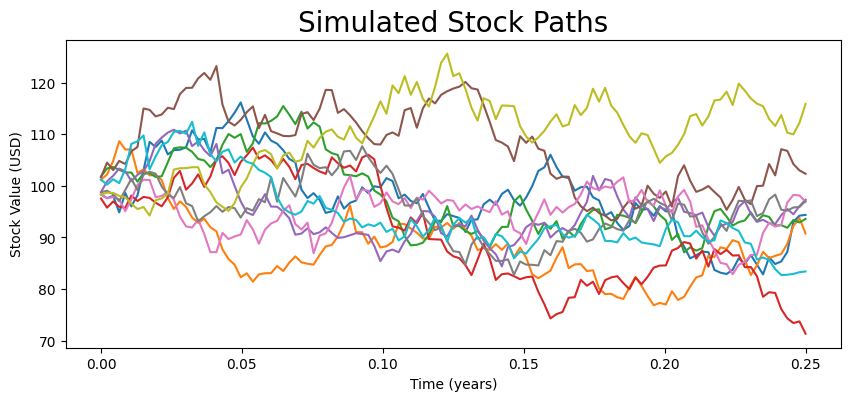

In [3]:
# Simulate GBM paths
S0 = 100
sigma = .45
t = 3/12
r = .035
mu = 0
n_sims = 10
n_steps = 117
stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)

time = np.linspace(0,t, n_steps)
plt.figure(figsize=(10,4))
for path in stock_paths:
    plt.plot(time, path)
plt.xlabel('Time (years)')
plt.ylabel('Stock Value (USD)')
plt.title('Simulated Stock Paths', size = 20)
plt.show()

## Pricing Asian Options

There are numerous permutations of Asian option; the most basic are listed below:


An **(Asian) call option** is a contract between two parties, a buyer and a seller, that gives the buyer the right, but not the obligation, to buy an underlying asset to the seller for a predetermined price $K$, called the strike price at a future point of time.

A **(Asian) put option** is a contract between two parties, a buyer and a seller, that gives the buyer the right, but not the obligation, to sell an underlying asset to the seller for a predetermined price $K$, called the strike price at a future point of time.



### Fair Market Price of an Asian Option Contract

#### Asian call options

Let $S_t$ denote the value of a stock at a time $t$. Consider a call option on the stock with strike price $K$ and expires at time $t$. The value of the call option at the expiration time $t$ is $$\max\left(\frac{1}{m}\sum_{i=1}^m S(t_i)-K,0\right).$$


The **fair market value** of the call option at time $0$ is the expected value of $\max\left(\frac{1}{m}\sum_{i=1}^m S(t_i)-K,0\right)$ discounted to time $0$, i.e., 

$$C_0 = e^{-rt}\mathbb{E}\left[\max\left(\frac{1}{m}\sum_{i=1}^m S(t_i)-K,0\right)\right].$$



#### Asian put options

Let $S_t$ denote the value of a stock at a time $t$. Consider a put option on the stock with strike price $K$ and expires at time $t$. The value of the put option at the expiration time $t$ is $$\max\left(K - \frac{1}{m}\sum_{i=1}^m S(t_i),0\right).$$


The **fair market value** of the put option at time $0$ is the expected value of $\max(S_t-K,0)$ discounted to time $0$, i.e., 

$$P_0 = e^{-rt}\mathbb{E}\left[\max\left(K - \frac{1}{m}\sum_{i=1}^m S(t_i),0\right)\right].$$

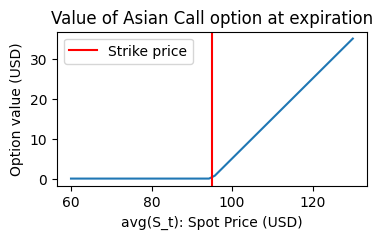

In [4]:
## Plot Value of Asian call option at expiration

# Spot price = price of the underlying stock
K = 95

spot_price = np.linspace(60,200)
plt.figure(figsize=(4,2))
means = np.cumsum(spot_price) / np.arange(1,len(spot_price)+1)
plt.plot(means, np.maximum(means-K,0))
plt.axvline(x = K , c = 'red', label = 'Strike price')
plt.title('Value of Asian Call option at expiration')
plt.xlabel('avg(S_t): Spot Price (USD)')
plt.ylabel('Option value (USD)')
plt.legend()
plt.show()

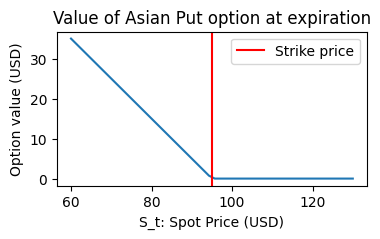

In [5]:
## Plot Value of Asian put option at expiration

# Spot price = price of the underlying stock
K = 95

spot_price = np.linspace(60,200)
plt.figure(figsize=(4,2))
means = np.cumsum(spot_price) / np.arange(1,len(spot_price)+1)
plt.plot(means, np.maximum(K- means,0))
plt.axvline(x = K , c = 'red', label = 'Strike price')
plt.title('Value of Asian Put option at expiration')
plt.xlabel('S_t: Spot Price (USD)')
plt.ylabel('Option value (USD)')
plt.legend()
plt.show()

### Option pricing via Monte-Carlo Methods

It we assume a model of stock prices $S_t$, then we can use Monte-Carlo methods to estimate the values $$C_0 = e^{-rt}\mathbb{E}\left[\max\left(\frac{1}{m}\sum_{i=1}^m S(t_i)-K,0\right)\right]$$ and $$P_0 = e^{-rt}\mathbb{E}\left[\max\left(K - \frac{1}{m}\sum_{i=1}^m S(t_i),0\right)\right].$$

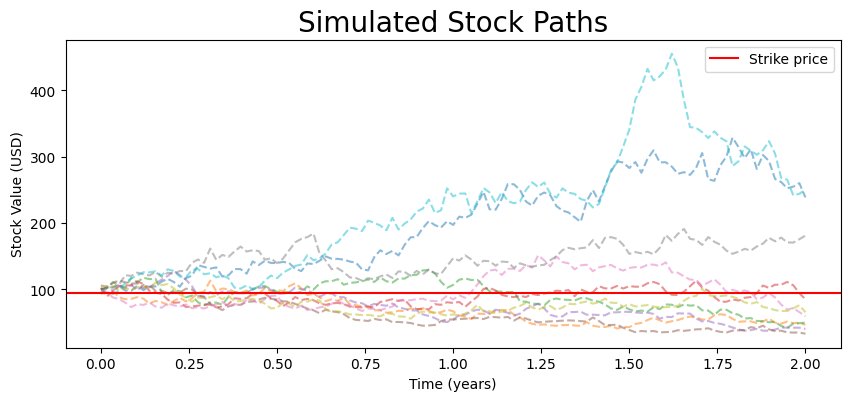

Estimated Asian call value (discounted to time 0): $26.65


In [6]:
#Plot simulated paths with horizontal strike price
S0 = 100
sigma = .45
t = 2
r = .035
mu = 0
n_sims = 1_0
n_steps = 117
stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)


K = 95

time = np.linspace(0,t, n_steps)
plt.figure(figsize=(10,4))
for path in stock_paths:
    plt.plot(time, path, alpha = .5, ls = '--')



plt.axhline(K, c = 'r', label = 'Strike price')

plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Stock Value (USD)')
plt.title('Simulated Stock Paths', size = 20)
plt.show()

path_means = np.mean(stock_paths, axis=1)

call_values = np.maximum(path_means - K, 0)

call_values_discounted = np.exp(-r*t)*call_values

# Montecarlo estimation
call_values_estimated = np.mean(call_values_discounted)

print(f'Estimated Asian call value (discounted to time 0): ${call_values_estimated:.2f}')

### How does the pricing varies wrt other quantities?

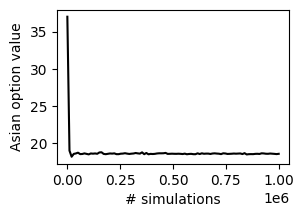

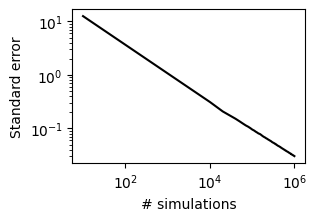

In [7]:
# Increase number of simulations to decrease standard error of estimate
S0 = 100
sigma = .4
t = 2
r = .035
mu = 0
# simulation_amounts = [10, 100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000] # HERE we try increasing number of sims
simulation_amounts = list(map(int,np.linspace(10,1_000_000,100)))
n_steps = 5

# arrays to plot
call_values_discounted_array = []
std_err_array = []

for n_sims in simulation_amounts:
    time = np.linspace(0,t, n_steps + 1)
    stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)

    K = 95
    path_means = np.mean(stock_paths, axis=1)

    call_values = np.maximum(path_means - K, 0)

    call_values_discounted = np.exp(-r*t)*call_values
    
    # Montecarlo estimation
    call_values_estimated = np.mean(call_values_discounted)
    call_values_discounted_array.append(call_values_estimated)
    std_err = np.std(call_values_discounted)/np.sqrt(n_sims)
    std_err_array.append(std_err)
    # print(f'Estimated Asian call value (discounted to time 0) with simulations {n_sims}: ${call_values_estimated:.2f} with standard error: {std_err:5f}')
    # print('---'*20)
    # print('---'*20)

# value vs. #_sims
plt.figure(figsize=(3,2))
plt.plot(simulation_amounts,call_values_discounted_array, c='black')
plt.ylabel('Asian option value')
plt.xlabel('# simulations')
plt.show()

# std_value vs. #_sims
plt.figure(figsize=(3,2))
plt.plot(simulation_amounts,std_err_array, c='black')
# plt.plot(simulation_amounts,1/np.sqrt(simulation_amounts))
plt.ylabel('Standard error')
plt.xlabel('# simulations')
plt.yscale('log')
plt.xscale('log')
plt.show()

Estimated Asian call value (discounted to time 0) with strike price 70: $34.14 with standard error: 0.036285
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with strike price 80: $27.02 with standard error: 0.034219
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with strike price 90: $21.16 with standard error: 0.031791
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with strike price 100: $16.29 with standard error: 0.028971
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with strike price 110: $1

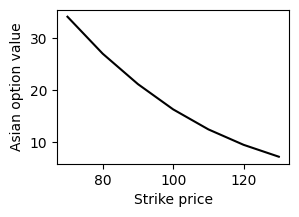

In [8]:
#Examine impact of strike price on the estimated price of a call option
S0 = 100
sigma = .4
t = 2
r = .035
mu = 0
strike_prices = [70,80,90,100,110,120,130]
n_steps = 5
n_sims = 1_000_000

# arrays to plot
call_values_discounted_array = []

for K in strike_prices:
    time = np.linspace(0,t, n_steps + 1)
    stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)

    
    path_means = np.mean(stock_paths, axis=1)

    call_values = np.maximum(path_means - K, 0)

    call_values_discounted = np.exp(-r*t)*call_values
    
    # Montecarlo estimation
    call_values_estimated = np.mean(call_values_discounted)
    call_values_discounted_array.append(call_values_estimated)
    std_err = np.std(call_values_discounted)/np.sqrt(n_sims)
    print(f'Estimated Asian call value (discounted to time 0) with strike price {K}: ${call_values_estimated:.2f} with standard error: {std_err:5f}')
    print('---'*20)
    print('---'*20)

# value vs. #_sims
plt.figure(figsize=(3,2))
plt.plot(strike_prices,call_values_discounted_array, c='black')
plt.ylabel('Asian option value')
plt.xlabel('Strike price')
plt.show()

Estimated Asian call value (discounted to time 0) with volatility 0.2: $12.13 with standard error: 0.014837
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with volatility 0.25: $13.67 with standard error: 0.018385
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with volatility 0.3: $15.32 with standard error: 0.022137
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with volatility 0.4: $18.57 with standard error: 0.030426
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with volatility 0.5: $21.78 w

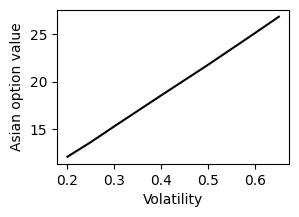

In [9]:
#Examine impact of volatility on the estimated price of a call option
S0 = 100
K = 95
sigma = .4
t = 2
r = .035
mu = 0
volatilities = [.2,.25,.3,.4,.5,.6,.65]
n_steps = 5
n_sims = 1_000_000

# arrays to plot
call_values_discounted_array = []

for sigma in volatilities:
    time = np.linspace(0,t, n_steps + 1)
    stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)

    
    path_means = np.mean(stock_paths, axis=1)

    call_values = np.maximum(path_means - K, 0)

    call_values_discounted = np.exp(-r*t)*call_values
    
    # Montecarlo estimation
    call_values_estimated = np.mean(call_values_discounted)
    call_values_discounted_array.append(call_values_estimated)
    std_err = np.std(call_values_discounted)/np.sqrt(n_sims)
    print(f'Estimated Asian call value (discounted to time 0) with volatility {sigma}: ${call_values_estimated:.2f} with standard error: {std_err:5f}')
    print('---'*20)
    print('---'*20)

# value vs. #_sims
plt.figure(figsize=(3,2))
plt.plot(volatilities,call_values_discounted_array, c='black')
plt.ylabel('Asian option value')
plt.xlabel('Volatility')
plt.show()

Estimated Asian call value (discounted to time 0) with maturity 0.003968253968253968: $5.00 with standard error: 0.001668
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with maturity 0.25: $8.32 with standard error: 0.010162
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with maturity 0.5: $10.55 with standard error: 0.014247
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with maturity 0.75: $12.32 with standard error: 0.017532
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with maturity 1: $13.

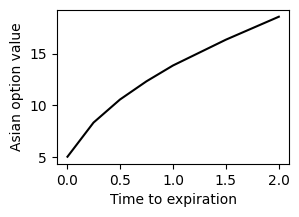

In [10]:
#Examine impact of time to expiration on the estimated price of a call option
S0 = 100
K = 95
sigma = .4
times = [1/252,3/12,1/2,3/4,1,1.5,2]
r = .035
mu = 0
sigma = .4
n_steps = 5
n_sims = 1_000_000

# arrays to plot
call_values_discounted_array = []

for t in times:
    time = np.linspace(0,t, n_steps + 1)
    stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)

    
    path_means = np.mean(stock_paths, axis=1)

    call_values = np.maximum(path_means - K, 0)

    call_values_discounted = np.exp(-r*t)*call_values
    
    # Montecarlo estimation
    call_values_estimated = np.mean(call_values_discounted)
    call_values_discounted_array.append(call_values_estimated)
    std_err = np.std(call_values_discounted)/np.sqrt(n_sims)
    print(f'Estimated Asian call value (discounted to time 0) with maturity {t}: ${call_values_estimated:.2f} with standard error: {std_err:5f}')
    print('---'*20)
    print('---'*20)

# value vs. #_sims
plt.figure(figsize=(3,2))
plt.plot(times,call_values_discounted_array, c='black')
plt.ylabel('Asian option value')
plt.xlabel('Time to expiration')
plt.show()

Estimated Asian call value (discounted to time 0) with interest rate %0: $12.30 with standard error: 0.018804
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with interest rate %1.0: $12.52 with standard error: 0.018898
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with interest rate %1.5: $12.63 with standard error: 0.018924
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with interest rate %2.0: $12.69 with standard error: 0.018932
------------------------------------------------------------
------------------------------------------------------------
Estimated Asian call value (discounted to time 0) with interest ra

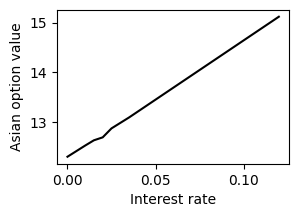

In [11]:
#Examine impact of risk_free interest rate on the estimated price of a call option
S0 = 100
K = 95
sigma = .4
t = 1
rates = [0,.01,.015,.02,.025,.035,.12]
mu = 0
sigma = .4
n_steps = 10
n_sims = 1_000_000

# arrays to plot
call_values_discounted_array = []

for r in rates:
    time = np.linspace(0,t, n_steps + 1)
    stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)

    
    path_means = np.mean(stock_paths, axis=1)

    call_values = np.maximum(path_means - K, 0)

    call_values_discounted = np.exp(-r*t)*call_values
    
    # Montecarlo estimation
    call_values_estimated = np.mean(call_values_discounted)
    call_values_discounted_array.append(call_values_estimated)
    std_err = np.std(call_values_discounted)/np.sqrt(n_sims)
    print(f'Estimated Asian call value (discounted to time 0) with interest rate %{r*100}: ${call_values_estimated:.2f} with standard error: {std_err:5f}')
    print('---'*20)
    print('---'*20)

# value vs. #_sims
plt.figure(figsize=(3,2))
plt.plot(rates,call_values_discounted_array, c='black')
plt.ylabel('Asian option value')
plt.xlabel('Interest rate')
plt.show()

## Pricing of Asian Call Option:  MonteCarlo vs. PDE

In [12]:
# === Contract & model parameters ===
S0     = 100.0     # Initial spot price S_0
K      = 95     # Strike
r      = 0.05      # Risk-free rate (annualized, continuously compounded)
sigma  = 0.2       # Volatility (annualized)
T      = 1.0       # Maturity in years
n_obs  = 12        # Number of equally spaced observation dates for the arithmetic average
mu = 0

# === Monte Carlo controls ===
n_paths = 1_000_000  # Number of simulated price paths
# seed    = 12345    # RNG seed for reproducibility

# === PDE grid controls ===
Nz      = 801      # Number of spatial grid points in z
Nt      = 480      # Number of time steps for backward Euler
z_min   = -1.5     # Left boundary for z
z_max   =  2.5     # Right boundary for z

In [13]:
def mc_arithmetic_asian_call_price(S0, K, r, sigma, T, n_obs, n_paths):
    """
    Price an arithmetic **discrete** Asian call via Monte Carlo under risk-neutral GBM.
    
    Parameters
    ----------
    S0, K, r, sigma, T : float
        Usual Black–Scholes inputs.
    n_obs : int
        Number of equally spaced observation dates in (0,T].
    n_paths : int
        Number of Monte Carlo paths.
    
    Returns
    -------
    price : float
        Discounted Monte Carlo estimator of the option price.
    stderr : float
        Standard error of the estimator (use 1.96*stderr for a 95% CI).
    """

    stock_paths = GBM_paths(S0, sigma, T, r, mu, n_paths, n_obs)

    
    sum_S = stock_paths.sum(axis=1)                    # sum over observation dates (no S0)
    
    A = sum_S / n_obs                            # Arithmetic average across observation dates
    payoff = np.maximum(A - K, 0.0)              # Asian call payoff
    disc_payoff = np.exp(-r * T) * payoff        # Risk-neutral discounting to t=0
    
    # Monte Carlo price is the sample mean; the standard error is s/sqrt(N).
    price  = disc_payoff.mean()
    stderr = disc_payoff.std(ddof=1) / np.sqrt(n_paths)
    return price, stderr

mc_price, mc_stderr = mc_arithmetic_asian_call_price(S0, K, r, sigma, T, n_obs, n_paths)
mc_ci95 = (mc_price - 1.96*mc_stderr, mc_price + 1.96*mc_stderr)
print(f'Montecarlo estimate ${mc_price}, with 95% CI ({mc_ci95[0]},{mc_ci95[1]})' )

Montecarlo estimate $9.204786425855602, with 95% CI (9.185363849438502,9.224209002272701)


### PDE solver (Backward Euler, central differences)

We solve backward in time the PDE  

$$
u_t + r(q_t - z)u_z + \tfrac{1}{2} (q_t - z)^2 \sigma^2 u_{zz} = 0,
$$

with terminal condition  
$$
u(T, z) = z^+.
$$

**Discretization**

* **Time:** uniform grid $ t_k = k\,\Delta t $, march **backwards** \( k = N_t, \dots, 0 \).  
* **Space:** uniform grid $ z_i = z_{\min} + i\,\Delta z $, $ i = 0, \dots, N_z - 1 $.  
* **Derivatives:** central differences for $ u_z $ and $ u_{zz} $.  
* **Scheme:** **Backward Euler**, i.e.
  $$
  u^{k} - \Delta t\,\mathcal{L}(t_{k+1})\,u^{k} = u^{k+1},
  $$
  where  
  $$
  \mathcal{L}(t) = r(q_t - z)\,\partial_z + \tfrac{1}{2} (q_t - z)^2 \sigma^2 \partial_{zz}.
  $$
* **Boundary conditions:** we enforce simple Dirichlet values motivated by the payoff’s linear growth:  
  $ u(t, z_{\min}) \approx 0 $ and $ u(t, z_{\max}) \approx z_{\max}^+ = z_{\max} $.  


In [14]:
# q
def q_piecewise(t, T, n):
    """Piecewise-constant q(t) = 1 - (1/n) * floor(n * t / T)."""
    return 1.0 - (np.floor(n * t / T) / n)
# PDE solver
def solve_pde_u0(r, sigma, T, n, z_min, z_max, Nz, Nt):
    """
    Solve the PDE for u(t,z) backward to t=0 and return u(0, z-grid) and the grid itself.
    
    Implements backward Euler with central differences and Dirichlet boundaries:
      u(t, z_min) = 0,   u(t, z_max) = z_max.
    """
    # --- Grids ---
    z = np.linspace(z_min, z_max, Nz)       # Spatial grid
    dz = z[1] - z[0]                        # Spatial step
    t = np.linspace(0.0, T, Nt+1)           # Time grid
    dt = t[1] - t[0]                        # Time step
    
    # --- Terminal condition: u(T,z) = z^+ ---
    u_next = np.maximum(z, 0.0)             # u at time level k+1 (starting from T)
    
    # --- Convenience: indices of interior points (where PDE applies) ---
    I = np.arange(1, Nz-1)                  # 1..Nz-2
    
    for k in range(Nt-1, -1, -1):           # k = Nt-1, ..., 0  (backwards in time)
        tk1 = t[k+1]                        # Use coefficients at the implicit time t_{k+1}
        qk  = q_piecewise(tk1, T, n)        # q_{t_{k+1}} per theorem
        
        # Coefficients at grid points (vectorized on z)
        a = 0.5 * (qk - z[I])**2 * sigma**2  # diffusion coefficient a(z,t)
        b = r * (qk - z[I])                  # advection coefficient b(z,t)
        
        # Construct tridiagonal matrix for (I - dt L) with central differences:
        # L u ≈ b*(u_{i+1}-u_{i-1})/(2dz) + a*(u_{i+1}-2u_i+u_{i-1})/dz^2
        
        # Diagonal and off-diagonal contributions
        main = 1.0 + dt * (2.0*a / dz**2)                   # from -dt * a*(-2)/dz^2
        upper = -dt * ( (a / dz**2) + (b / (2.0*dz)) )      # coefficient multiplying u_{i+1}
        lower = -dt * ( (a / dz**2) - (b / (2.0*dz)) )      # coefficient multiplying u_{i-1}
        
        # Assemble dense tri-diagonal system for interior unknowns u^k_I
        Nint = Nz - 2
        A = np.zeros((Nint, Nint), dtype=float)
        # Fill tridiagonal bands
        A[np.arange(Nint), np.arange(Nint)] = main
        A[np.arange(Nint-1), np.arange(1, Nint)] = upper[:-1]
        A[np.arange(1, Nint), np.arange(Nint-1)] = lower[1:]
        
        # Right-hand side is just u_next at interior points, with boundary contributions added
        rhs = u_next[I].copy()
        # Add boundary terms from Dirichlet values at i=0 and i=Nz-1
        u_left  = 0.0              # u(t, z_min) ≈ 0
        u_right = z[-1]            # u(t, z_max) ≈ z_max
        rhs[0]  -= lower[0]  * u_left
        rhs[-1] -= upper[-1] * u_right
        
        # Solve for the new interior values u^k_I
        u_I = solve(A, rhs)
        
        # Build full u at time level k
        u_curr = np.empty_like(u_next)
        u_curr[0]     = u_left
        u_curr[-1]    = u_right
        u_curr[I]     = u_I
        
        # March to the next step
        u_next = u_curr
    
    # On exit, u_next holds u at t=0
    return z, u_next

z_grid, u0_on_grid = solve_pde_u0(r, sigma, T, n_obs, z_min, z_max, Nz, Nt)

# Interpolate u(0, z0) for z0 = X0 / S0 with X0 = S0 - K
z0 = (S0 - K) / S0
# Simple linear interpolation on the z-grid
u0_at_z0 = np.interp(z0, z_grid, u0_on_grid)
pde_price = S0 * u0_at_z0
print(f'PDE estimate: {pde_price}')

PDE estimate: 9.173084467566465


## Final comparison

In [15]:
print(f"Monte Carlo price     : {mc_price: .6f}")
print(f"  95% CI              : [{mc_ci95[0]: .6f}, {mc_ci95[1]: .6f}]\n")
print(f"PDE price             : {pde_price: .6f}")
print(f"Absolute difference   : {abs(pde_price - mc_price): .6f}")

Monte Carlo price     :  9.204786
  95% CI              : [ 9.185364,  9.224209]

PDE price             :  9.173084
Absolute difference   :  0.031702
